# Download The Data:
https://figshare.com/articles/dataset/Deep_Image_Reconstruction/7033577?file=14830631
https://figshare.com/articles/dataset/Deep_Image_Reconstruction/7033577?file=14830862

In [29]:
!pip install bdpy

In [30]:
import h5py
import numpy as np
from matplotlib import pyplot as plt
import bdpy
import tensorflow as tf

In [31]:
train_bdata = bdpy.BData('../../fMRI data/sub-01_perceptionNaturalImageTraining_original_VC.h5')
test_bdata = bdpy.BData('../../fMRI data/sub-01_perceptionNaturalImageTest_original_VC.h5')
# train_data.show_metadata()

train_data = train_bdata.select("ROI_HVC")
test_data = test_bdata.select("ROI_HVC")

all_data = tf.concat((train_data, test_data), axis=0)
print(all_data.shape)

(7200, 5066)


In [32]:
dmin, dmax = min(np.min(all_data), np.min(all_data)), max(np.max(all_data), np.max(all_data))
dscale = max(abs(dmin), abs(dmax))
print("dmin: ", dmin, "dmax: ", dmax)
print("dscale: ", dscale)

X = train_data / dscale 
X = tf.math.tanh(X)

print("xmin: ", np.min(X), "xmax: ", np.max(X))

dmin:  -241.36007503271463 dmax:  246.3444600442728
dscale:  246.3444600442728
xmin:  -0.7529648519104515 xmax:  0.7404891052904956


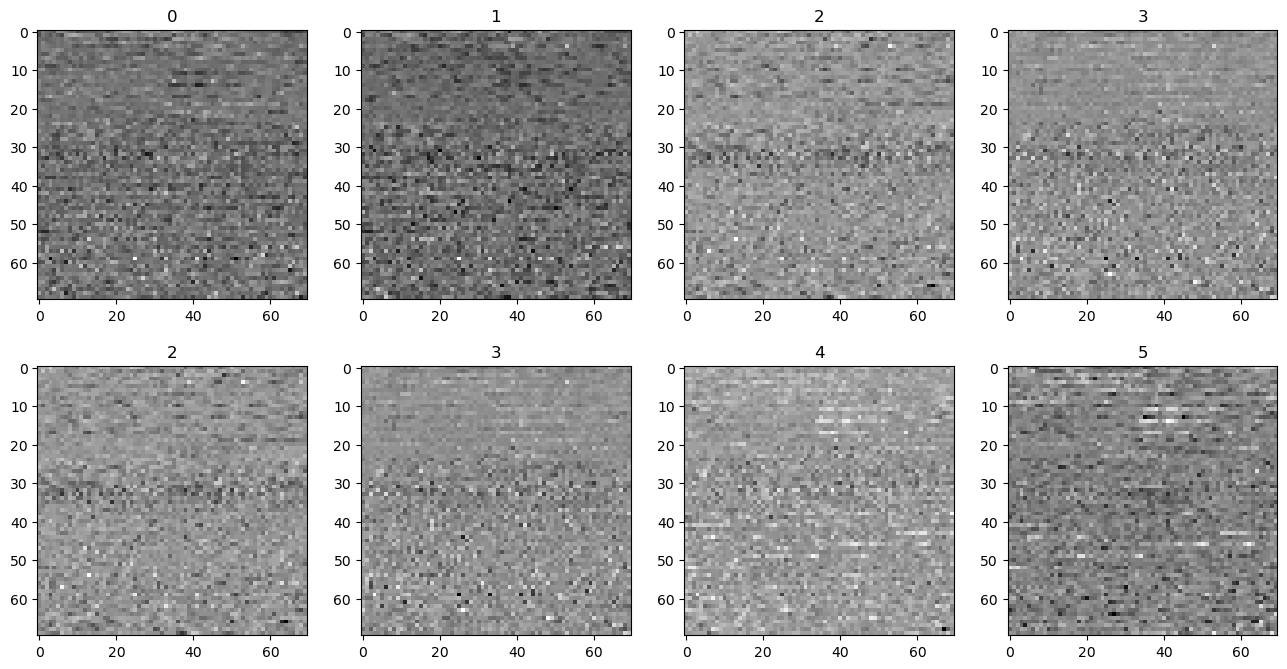

In [33]:
image_samples = np.reshape(X[:, :4900], (-1, 70, 70))

rows = 2
fig, ax = plt.subplots(nrows=rows, ncols=4)
for r in range(rows):
    for c in range(4):
        sample_img = image_samples[2*r + c]
        ax[r][c].imshow(sample_img, cmap="gray")
        ax[r][c].set_title(f'{2*r+c}')

fig.set_size_inches(16, 4*rows)

plt.show()

In [34]:
%load_ext autoreload
%autoreload 2

In [35]:
from tensorflow.keras.layers import *
latent_dim = 256

encoder = tf.keras.Sequential([
    Input((5066)),
    Dense(2*latent_dim, activation="tanh"),
    # Dense(2*latent_dim, activation="tanh"),
    Dense(2*latent_dim),
], name = "encoder")

encoder.summary()

Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 512)               2594304   
_________________________________________________________________
dense_1 (Dense)              (None, 512)               262656    
Total params: 2,856,960
Trainable params: 2,856,960
Non-trainable params: 0
_________________________________________________________________


In [36]:
decoder = tf.keras.Sequential([
    Input((latent_dim)),
    Dense(2*latent_dim, activation="tanh"),
    # Dense(2*latent_dim, activation="tanh"),
    Dense(5066, activation="tanh"),
], name = "decoder")

decoder.summary()

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 512)               131584    
_________________________________________________________________
dense_3 (Dense)              (None, 5066)              2598858   
Total params: 2,730,442
Trainable params: 2,730,442
Non-trainable params: 0
_________________________________________________________________


In [51]:
from autoencoder import VAE
from autoencoder import KL_Callback

kl_beta = tf.Variable(0.0, trainable=False)
kl_callback = KL_Callback(kl_beta=kl_beta)

vae = VAE(encoder, decoder)
vae.build((None, 5066))
vae.compile(
      optimizer=tf.keras.optimizers.Adam()
)
vae.summary()

Model: "vae_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder (Sequential)         (None, 512)               2856960   
_________________________________________________________________
decoder (Sequential)         (None, 5066)              2730442   
Total params: 5,587,408
Trainable params: 5,587,402
Non-trainable params: 6
_________________________________________________________________


# Train

In [52]:
vae.fit(
    X, 
    epochs=30, 
    batch_size=32,
    callbacks=[kl_callback]
    )

Epoch 1/30
kl_beta: <tf.Variable 'Variable:0' shape=() dtype=float32, numpy=0.0>
(None, 256)
(None, 256)
188/188 [==============================] - 2s 11ms/step - loss: 0.0015 - reconstruction_loss: 0.0015 - kl_loss: 3.1785e-06
Epoch 2/30
kl_beta: <tf.Variable 'Variable:0' shape=() dtype=float32, numpy=0.0>
188/188 [==============================] - 2s 10ms/step - loss: 0.0015 - reconstruction_loss: 0.0016 - kl_loss: 5.1676e-06
Epoch 3/30
kl_beta: <tf.Variable 'Variable:0' shape=() dtype=float32, numpy=1.0>
188/188 [==============================] - 2s 11ms/step - loss: 0.0016 - reconstruction_loss: 0.0016 - kl_loss: 5.2627e-06
Epoch 4/30
kl_beta: <tf.Variable 'Variable:0' shape=() dtype=float32, numpy=1.0>
 66/188 [=========>....................] - ETA: 1s - loss: 0.0015 - reconstruction_loss: 0.0015 - kl_loss: 5.0772e-06

KeyboardInterrupt: 

# Plot Reconstruction

-0.2255970757932964 0.18997213162640977
-0.20172979 0.20159428


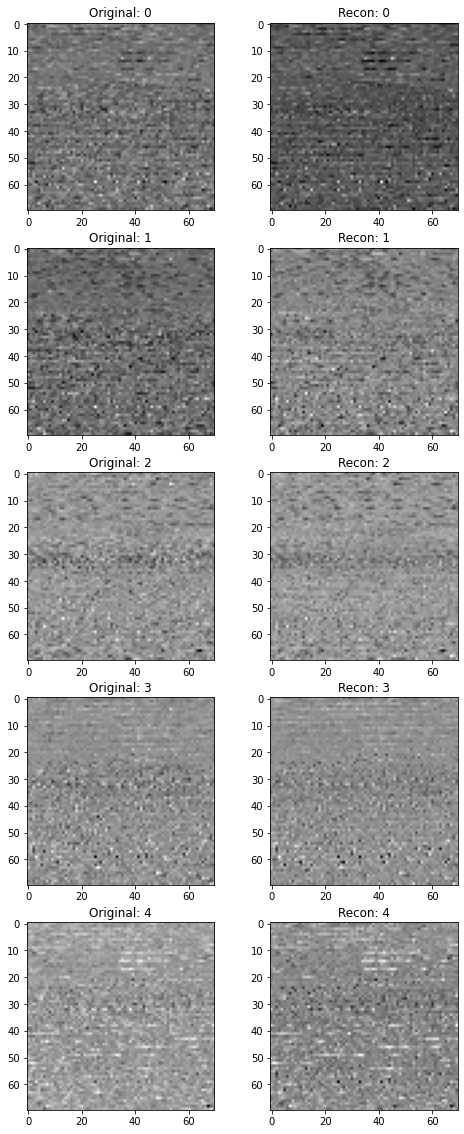

In [83]:
n = 5

test_sample = X[:n]
print(np.min(test_sample), np.max(test_sample))

recon = vae(test_sample)
print(np.min(recon), np.max(recon))

fig, ax = plt.subplots(nrows=n, ncols=2)

fig.set_size_inches((8, 4*n))

test_sample = np.reshape(test_sample[:,:4900], (-1, 70, 70))
recon = np.reshape(recon[:,:4900], (-1, 70, 70))

for i in range(n):
  ax[i][0].imshow(test_sample[i], cmap="gray")
  ax[i][0].set_title(f'Original: {i}')
  ax[i][1].imshow(recon[i], cmap="gray")
  ax[i][1].set_title(f'Recon: {i}')

# Save Model

In [84]:
import time
t = int(time.time())

vae.save(f'./Trained Models/VAE/trained_vae_model_{t}')

# Get Embeddings

In [5]:
training_embeddings = model.encoder(train_data)
testing_embeddings = model.encoder(test_data)
print(training_embeddings.shape)
print(testing_embeddings.shape)

(6000, 512)
(1200, 512)


# Load Model

In [4]:
model = tf.keras.models.load_model('./Trained Models/VAE/trained_vae_model_1670286874')

In [27]:
import json

fn_idx = []
test_fn_idx = []
with open('../metadata/stimulus_perceptionNaturalImageTraining.tsv') as f:
    fn_idx = f.read().splitlines()
    fn_idx = [l.split('\t')[0] for l in fn_idx]

with open('../metadata/stimulus_perceptionNaturalImageTest.tsv') as f:
    test_fn_idx = f.read().splitlines()
    test_fn_idx = [l.split('\t')[0] for l in test_fn_idx]

print(len(fn_idx))
print(len(test_fn_idx))

with open('./directory.json', 'w') as f:
    directory = {}
    for s, sample in enumerate(training_embeddings):
        filename = fn_idx[s%1200]
        embedding = sample.numpy().tolist()

        if filename in directory:
            directory[filename].append(embedding)
        else:
            directory[filename] = [embedding]
    
    for s, sample in enumerate(testing_embeddings):
        filename = test_fn_idx[s%50]
        embedding = sample.numpy().tolist()

        if filename in directory:
            directory[filename].append(embedding)
        else:
            directory[filename] = [embedding]

    print(len(directory))
    print(len(directory[list(directory.keys())[0]]))
            
    json.dump(directory, f)

1200
50
1250
5


In [25]:
with open('../../imagenet/fmri_images/directory.json','r') as f:
    j = json.load(f)

    print(list(j.keys())[:10])

['n01518878_10042', 'n01518878_12028', 'n01518878_14075', 'n01518878_14910', 'n01518878_5958', 'n01518878_7346', 'n01518878_7579', 'n01518878_8432', 'n01639765_22407', 'n01639765_32862']


In [17]:
import glob

all_images = list(glob.iglob('../../imagenet/fmri_images/**/*.JPEG' , recursive=True))

print(f'allimages: {len(all_images)}')

print(len(directory))

allimages: 1243
1200
